In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def plot_hist(df, col, label):
    plt.hist(df[col], label = label)
    plt.legend()
    plt.show()

### 1. Data Preparation

In [0]:
# General imports
import numpy as np
np.random.seed(0)
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os, sys, gc, warnings, random, datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import math

warnings.filterwarnings('ignore')

In [0]:
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
## ------------------- 

## -------------------
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
## -------------------

In [0]:
SEED = 42
seed_everything(SEED)
TARGET = 'isFraud'

In [6]:
# ----- Load Data -----
print('Loading Data..')

train_df = pd.read_csv('/content/drive/My Drive/Springboard Capstone 2/train_transaction.csv')
test_df = pd.read_csv('/content/drive/My Drive/Springboard Capstone 2/test_transaction.csv')
test_df['isFraud'] = 0

train_identity = pd.read_csv('/content/drive/My Drive/Springboard Capstone 2/train_identity.csv')
test_identity = pd.read_csv('/content/drive/My Drive/Springboard Capstone 2/test_identity.csv')

Loading Data..


In [7]:
train_df = reduce_mem_usage(train_df)
test_df  = reduce_mem_usage(test_df)

train_identity = reduce_mem_usage(train_identity)
test_identity  = reduce_mem_usage(test_identity)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 473.07 Mb (68.9% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


### 2. Data Preprocessing

In [0]:
base_columns = list(train_df) + list(train_identity)

**Dataset Columns**

**Transaction Data**

'TransactionID'

'isFraud'

'TransactionDT'

'TransactionAmt'

'ProductCD' **Categorical Features**

'card1' - 'card6' **Categorical Features**

'addr1' - 'addr2' **Categorical Features**

'dist1' - 'dist2'

'P_emaildomain' **Categorical Features**

'R_emaildomain' **Categorical Features**

'C1' - 'C14'

'D1' - 'D15'

'M1' - 'M9' **Categorical Features**

'V1' - 'V339'




**Identity Data**

'TransactionID'

'id_01' - 'id_38' **Categorical Features id_12 - id_38**

'DeviceType' **Categorical Features**

'DeviceInfo' **Categorical Features**

#### 2.1 Product CD

Here we look at product code distribution and percentage of fraud in ALL transactions associated with every product code

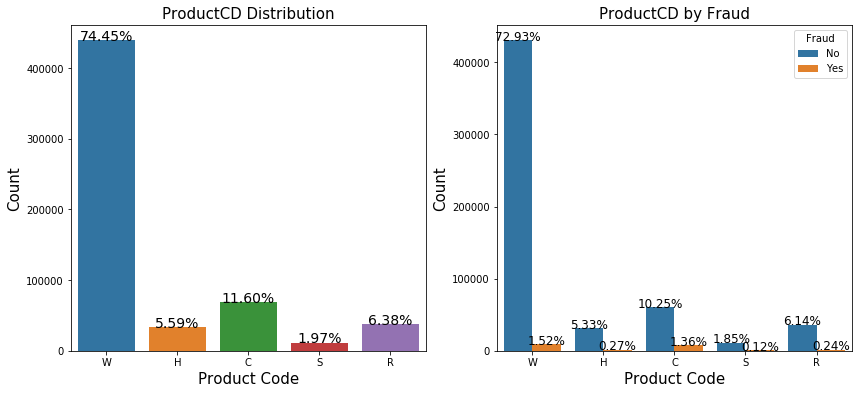

In [9]:
plt.figure(figsize=(14,6))

total = len(train_df)

plt.subplot(121)
g = sns.countplot(x = 'ProductCD', data = train_df)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_df)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

Now let's look at fraud transaction distribution in all product codes

In [10]:
train_df[train_df['isFraud'] == 1]['ProductCD'].value_counts(normalize = True)

W    0.434061
C    0.387553
H    0.076175
R    0.069012
S    0.033199
Name: ProductCD, dtype: float64

isFraud           0         1
ProductCD                    
C          0.883127  0.116873
H          0.952338  0.047662
R          0.962174  0.037826
S          0.941004  0.058996
W          0.979601  0.020399


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

<Figure size 1152x1152 with 0 Axes>

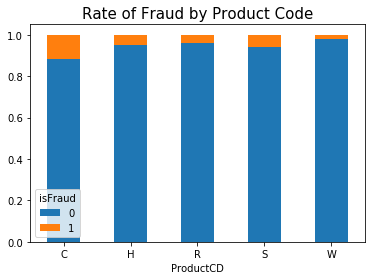

In [11]:
plt.figure(figsize = (16,16))
temp = train_df.groupby('ProductCD')['isFraud'].value_counts(normalize = True).unstack()
print(temp)
a = temp.plot.bar(stacked = True)
a.set_title('Rate of Fraud by Product Code', fontsize = 15)
plt.xticks(rotation = 'horizontal')

These results susgest that with product code, we need to do 2 things:
* Encode categorical levels using Frequency Encoding
* Add target mean by categorical level. It is found here that product C has highest fraud rate, compared to others

In [0]:
# ProductCD Frequency Encoding
col = 'ProductCD'
temp_df = pd.concat([train_df[[col]], test_df[[col]]])   # I don't want to use test data
#temp_df = train_df[[col]]
col_encoded = temp_df[col].value_counts().to_dict()
train_df[col] = train_df[col].map(col_encoded)
test_df[col]  = test_df[col].map(col_encoded)

### 2.2 Card1 - Card6

#### a. Card 1, 2, 3, 5

The card 1,2,3, and 5 was represented as numerical values, temping us to plot the histogram. However, we need to remember that card columns were classified as categorical variables. Meaning it's likely that these numerical variables were coded for categorical variables.

In [13]:
train_df.describe().loc[:,'card1':'card5']

,card1,card2,card3,card5
count,590540.000000,581607.0,588975.0,586281.0
mean,9898.734658,NaN,NaN,NaN
std,4901.170153,NaN,0.0,0.0
min,1000.000000,100.0,100.0,100.0
25%,6019.000000,214.0,150.0,166.0
50%,9678.000000,361.0,150.0,226.0
75%,14184.000000,512.0,150.0,226.0
max,18396.000000,600.0,231.0,237.0


In [14]:
train_df.loc[:,'card1':'card5'].nunique()

card1    13553
card2      500
card3      114
card4        4
card5      119
dtype: int64

In [0]:
########################### Reset values for "noise" card1
i_cols = ['card1']

for col in i_cols: 
    valid_card = pd.concat([train_df[[col]], test_df[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)

b. Card4

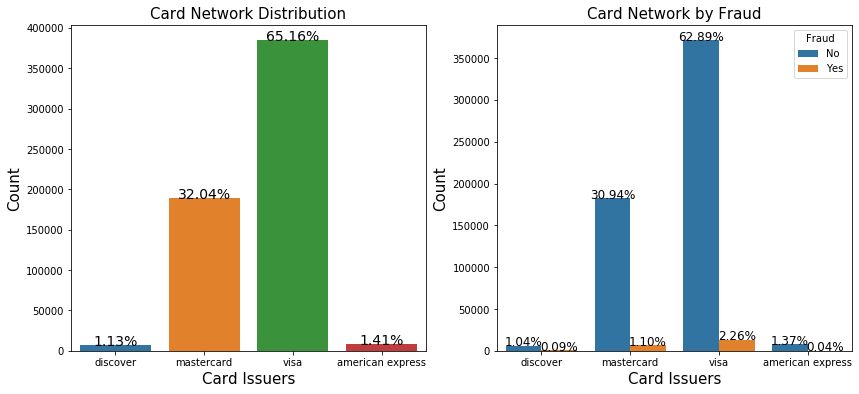

In [16]:
plt.figure(figsize=(14,6))

total = len(train_df)

plt.subplot(121)
g = sns.countplot(x = 'card4', data = train_df)
g.set_title('Card Network Distribution', fontsize = 15)
g.set_xlabel("Card Issuers", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card4', hue='isFraud', data=train_df)
g1.set_title('Card Network by Fraud', fontsize = 15)
g1.set_xlabel("Card Issuers", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 864x864 with 0 Axes>

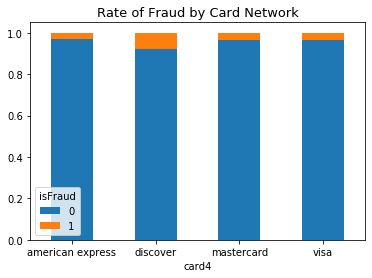

In [17]:
# visualization of table
plt.figure(figsize=(12,12))
b = train_df.groupby('card4')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
b.set_title('Rate of Fraud by Card Network', fontsize = 13)
plt.xticks(rotation='horizontal')

In [0]:
# Card4 Frequency Encoding
col = 'card4'
temp_df = pd.concat([train_df[[col]], test_df[[col]]])   # I don't want to use test data
#temp_df = train_df[[col]]
col_encoded = temp_df[col].value_counts().to_dict()
train_df[col] = train_df[col].map(col_encoded)
test_df[col]  = test_df[col].map(col_encoded)

## Card4 Target mean
#for col in ['card4']:
#    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
#                                                        columns={'mean': col+'_target_mean'})
#    temp_dict.index = temp_dict[col].values
#    temp_dict = temp_dict[col+'_target_mean'].to_dict()

#    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
#    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

c. Card6

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


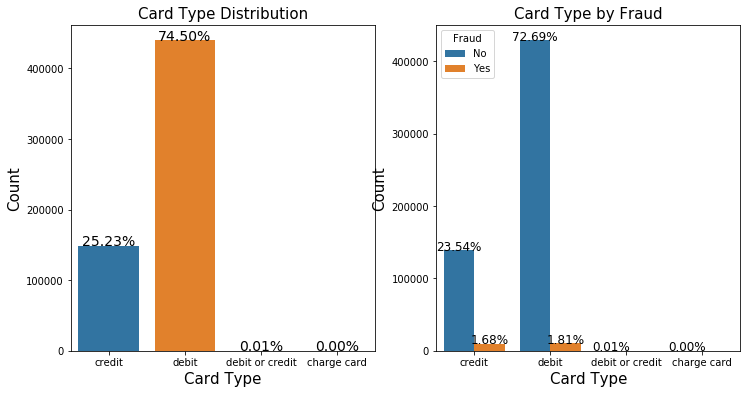

In [19]:
plt.figure(figsize=(12,6))

total = len(train_df)

plt.subplot(121)
g = sns.countplot(x = 'card6', data = train_df)
g.set_title('Card Type Distribution', fontsize = 15)
g.set_xlabel("Card Type", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card6', hue='isFraud', data=train_df)
g1.set_title('Card Type by Fraud', fontsize = 15)
g1.set_xlabel("Card Type", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 1152x1152 with 0 Axes>

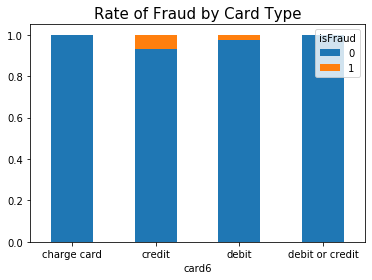

In [20]:
# visualization of table
plt.figure(figsize=(16,16))
c = train_df.groupby('card6')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
c.set_title('Rate of Fraud by Card Type', fontsize = 15)
plt.xticks(rotation='horizontal')

Credit card has much higher fraud rate as compared with other types of card

In [0]:
# Card6 Frequency Encoding
col = 'card6'
temp_df = pd.concat([train_df[[col]], test_df[[col]]])   # I don't want to use test data
#temp_df = train_df[[col]]
col_encoded = temp_df[col].value_counts().to_dict()
train_df[col] = train_df[col].map(col_encoded)
test_df[col]  = test_df[col].map(col_encoded)

## Card6 Target mean
#for col in ['card6']:
#    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
#                                                        columns={'mean': col+'_target_mean'})
#    temp_dict.index = temp_dict[col].values
#    temp_dict = temp_dict[col+'_target_mean'].to_dict()

#    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
#    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

### **2.3 'M1' - 'M9'**

In [22]:
temp = train_df.groupby('M4')['isFraud'].value_counts(normalize = True)
temp

M4  isFraud
M0  0          0.963351
    1          0.036649
M1  0          0.972949
    1          0.027051
M2  0          0.886261
    1          0.113739
Name: isFraud, dtype: float64

In [23]:
train_df['M4'].head()

0     M2
1     M0
2     M0
3     M0
4    NaN
Name: M4, dtype: object

In [24]:
for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    train_df[col] = train_df[col].map({'T':1, 'F':0})
    test_df[col]  = test_df[col].map({'T':1, 'F':0})
    
for col in ['M4']:
    print('Encoding', col)
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train_df[col] = train_df[col].map(col_encoded)
    test_df[col]  = test_df[col].map(col_encoded)
    print(col_encoded)

Encoding M4
{'M0': 357789, 'M2': 122947, 'M1': 97306}


### **2.4 'id_12' - 'id_38'**

In [0]:
# Identity columns

def minify_identity_df(df):

    df['id_12'] = df['id_12'].map({'Found':1, 'NotFound':0})
    df['id_15'] = df['id_15'].map({'New':2, 'Found':1, 'Unknown':0})
    df['id_16'] = df['id_16'].map({'Found':1, 'NotFound':0})

    df['id_23'] = df['id_23'].map({'TRANSPARENT':4, 'IP_PROXY':3, 'IP_PROXY:ANONYMOUS':2, 'IP_PROXY:HIDDEN':1})

    df['id_27'] = df['id_27'].map({'Found':1, 'NotFound':0})
    df['id_28'] = df['id_28'].map({'New':2, 'Found':1})

    df['id_29'] = df['id_29'].map({'Found':1, 'NotFound':0})

    df['id_35'] = df['id_35'].map({'T':1, 'F':0})
    df['id_36'] = df['id_36'].map({'T':1, 'F':0})
    df['id_37'] = df['id_37'].map({'T':1, 'F':0})
    df['id_38'] = df['id_38'].map({'T':1, 'F':0})

    df['id_34'] = df['id_34'].fillna(':0')
    df['id_34'] = df['id_34'].apply(lambda x: x.split(':')[1]).astype(np.int8)
    df['id_34'] = np.where(df['id_34']==0, np.nan, df['id_34'])
    
    df['id_33'] = df['id_33'].fillna('0x0')
    df['id_33_0'] = df['id_33'].apply(lambda x: x.split('x')[0]).astype(int)
    df['id_33_1'] = df['id_33'].apply(lambda x: x.split('x')[1]).astype(int)
    df['id_33'] = np.where(df['id_33']=='0x0', np.nan, df['id_33'])

    df['DeviceType'].map({'desktop':1, 'mobile':0})
    return df

train_identity = minify_identity_df(train_identity)
test_identity = minify_identity_df(test_identity)

for col in ['id_33']:
    train_identity[col] = train_identity[col].fillna('unseen_before_label')
    test_identity[col]  = test_identity[col].fillna('unseen_before_label')
    
    le = LabelEncoder()
    le.fit(list(train_identity[col])+list(test_identity[col]))
    train_identity[col] = le.transform(train_identity[col])
    test_identity[col]  = le.transform(test_identity[col])

### **3. Feature Engineering**

#### **3.1 TransactionDT**

In [0]:
START_DATE = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')

for df in [train_df, test_df]:
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: START_DATE + (datetime.timedelta(seconds = x)))
    df['DT_M'] = df['DT'].dt.month
    df['DT_W'] = df['DT'].dt.weekofyear
    df['DT_D'] = df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # D9 column
    df['D9'] = np.where(df['D9'].isna(),0,1)

#del train_df['DT']
#del test_df['DT']

In [0]:
# 'P_emaildomain' - 'R_emaildomain'
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

for df in [train_df, test_df]:
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])

In [0]:
# ---------- Device info ------------
for df in [train_identity, test_identity]:
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    # Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [0]:
# Merge Identity columns
temp_df = train_df[['TransactionID']]
temp_df = temp_df.merge(train_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
train_df = pd.concat([train_df,temp_df], axis=1)
    
temp_df = test_df[['TransactionID']]
temp_df = temp_df.merge(test_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
test_df = pd.concat([test_df,temp_df], axis=1)

#### **3.2 Frequency Encoding**


In [0]:
# Freq encoding
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
#          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
    test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)

In [31]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
        
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

P_emaildomain
R_emaildomain
P_emaildomain_prefix
R_emaildomain_prefix
id_30
id_31
DeviceType
DeviceInfo
DeviceInfo_device
DeviceInfo_version
id_30_device
id_30_version
id_31_device


In [32]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
gc.collect()

Mem. usage decreased to 648.43 Mb (24.7% reduction)
Mem. usage decreased to 564.13 Mb (24.4% reduction)


0

### **4. Clean up**

In [0]:
for col in list(train_df):
    if train_df[col].dtype == 'O':
        print(col)

In [0]:
rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

In [35]:
########################### Features elimination 
from scipy.stats import ks_2samp
features_check = []
columns_to_check = set(list(train_df)).difference(base_columns+rm_cols)
for i in columns_to_check:
    features_check.append(ks_2samp(test_df[i], train_df[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)

features_discard = [] 

# Final features list
features_columns = [col for col in list(train_df) if col not in rm_cols + features_discard]

['D6_fq_enc', 'id_31_device', 'D3_fq_enc', 'D5_fq_enc', 'D7_fq_enc', 'D4_fq_enc', 'id_30_version', 'C12_fq_enc']


In [36]:
train_df = reduce_mem_usage(train_df)
test_df  = reduce_mem_usage(test_df)

del train_identity, test_identity
gc.collect()

###########################
x_train_array = np.array(train_df[features_columns])
y_train_array = np.array(train_df[TARGET])#.values

x_train_array = x_train_array.astype('float16')
y_train_array = y_train_array.astype('float16')

for i in range(len(x_train_array)):
    x_train_array[i]=np.nan_to_num(x_train_array[i])
    y_train_array[i]=np.nan_to_num(y_train_array[i]) 

Mem. usage decreased to 648.43 Mb (0.0% reduction)
Mem. usage decreased to 564.13 Mb (0.0% reduction)


In [0]:
x_train_array_new = np.copy(x_train_array)
x_train_array_new = x_train_array_new.astype('float64')

In [0]:
n_col = x_train_array_new.shape[1]

for i in range(n_col):
  mean = np.mean(x_train_array_new[:,i])
  std = np.std(x_train_array_new[:,i])
  x_train_array_new[:,i] = (x_train_array_new[:,i] - mean)/std

In [39]:
x_train_array_new[:,100]

array([-0.57653258, -0.57653258, -0.57653258, ...,  1.45404881,
       -0.57653258,  1.45404881])

In [0]:
tr_x, vl_x, tr_y, vl_y = train_test_split( x_train_array_new, y_train_array, test_size=0.2, random_state=24, stratify=y_train_array)

### Pytorch

In [0]:
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


manualSeed = 1

np.random.seed(manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# Add seed to cuda for GPU use
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)


torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
gpu_use = True

In [44]:
tr_x.shape[0]//512

922

In [0]:
class fraud(Dataset):
    # Initialize your data, download, etc.
    def __init__(self):
        self.len = tr_x.shape[0]
        self.x_data = torch.from_numpy(tr_x)
        self.y_data = torch.from_numpy(tr_y)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
      
    def __len__(self):
        return self.len

In [0]:
def _init_fn():
    np.random.seed(manualSeed)

dataset = fraud()
batchsize = 32

train_loader = DataLoader(dataset=dataset, batch_size = batchsize, shuffle=True, num_workers = 0, worker_init_fn=_init_fn)

In [0]:
# Wrap in variable
if gpu_use:
    #x_train = Variable(torch.from_numpy(tr_x).cuda())   
    #y_train = Variable(torch.from_numpy(tr_y).cuda())   
    x_val = Variable(torch.from_numpy(vl_x).cuda())   
    y_val = Variable(torch.from_numpy(vl_y).cuda())   
else:
    #x_train = Variable(torch.from_numpy(tr_x))#.cuda()) 
    #y_train = Variable(torch.from_numpy(tr_y))#.cuda())   
    x_val = Variable(torch.from_numpy(vl_x))#.cuda())    
    y_val = Variable(torch.from_numpy(vl_y))#.cuda())     

In [0]:
input_dim = len(tr_x[0])

In [0]:
class Model_one(torch.nn.Module):

    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear module
        """
        super(Model_one, self).__init__()

# ==============================================
        self.l1 = torch.nn.Linear(input_dim, 1024)
        torch.nn.init.xavier_normal_(self.l1.weight)
        torch.nn.init.zeros_(self.l1.bias)
        
        self.l2 = torch.nn.Linear(1024, 1024)
        torch.nn.init.xavier_normal_(self.l2.weight)
        torch.nn.init.zeros_(self.l2.bias)

        self.l3 = torch.nn.Linear(1024, 512)
        torch.nn.init.xavier_normal_(self.l3.weight)
        torch.nn.init.zeros_(self.l3.bias)

        self.l4 = torch.nn.Linear(512, 256)
        torch.nn.init.xavier_normal_(self.l4.weight)
        torch.nn.init.zeros_(self.l4.bias)

        self.l5 = torch.nn.Linear(256, 128)
        torch.nn.init.xavier_normal_(self.l5.weight)
        torch.nn.init.zeros_(self.l5.bias)

        self.l6 = torch.nn.Linear(128, 64)
        torch.nn.init.xavier_normal_(self.l6.weight)
        torch.nn.init.zeros_(self.l6.bias)

        self.l7 = torch.nn.Linear(64, 1)
        torch.nn.init.xavier_normal_(self.l7.weight)
        torch.nn.init.zeros_(self.l7.bias)

# ============= Activation Functions ===================      
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        self.lrelu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()
        
        
    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """

        out1 = self.tanh(self.l1(x))
        out2 = self.tanh(self.l2(out1))
        out3 = self.tanh(self.l3(out2))
        out4 = self.tanh(self.l4(out3))
        out5 = self.tanh(self.l5(out4))
        out6 = self.tanh(self.l6(out5))
        
        y_pred = self.sigmoid(self.l7(out6))
        return y_pred

LEARNING RATE =  5e-06 ; Batch size =  32 ; wd =  0.0003
0 0.11464805097485214 0.09743062406778336 0.8690788711193992
4 0.08573726098199126 0.0904059186577797 0.8885484743487634
9 0.07878134783138618 0.08435451984405518 0.8983235411172504
14 0.07378000086710862 0.08017311245203018 0.90959905154066
19 0.06969251604579173 0.08065472543239594 0.9047285977696939
24 0.06616635089013469 0.07567553967237473 0.9193420978819677
29 0.06314257931466227 0.07711347192525864 0.9178113469622441
34 0.06075641785350769 0.07518120110034943 0.9211112798209268
39 0.058482939615477667 0.07363992184400558 0.9219355911447762
44 0.056559717608574755 0.07138807326555252 0.9288406895383042
49 0.05473639664155464 0.07233916968107224 0.9278590390040052
54 0.053271369012110846 0.07352833449840546 0.9263906295749674
59 0.05188032563768082 0.07057514786720276 0.9320913790622792
64 0.05072547358452555 0.07120588421821594 0.9289135520113286
69 0.04949778034384568 0.07253757119178772 0.9268527588415605
74 0.04866405008

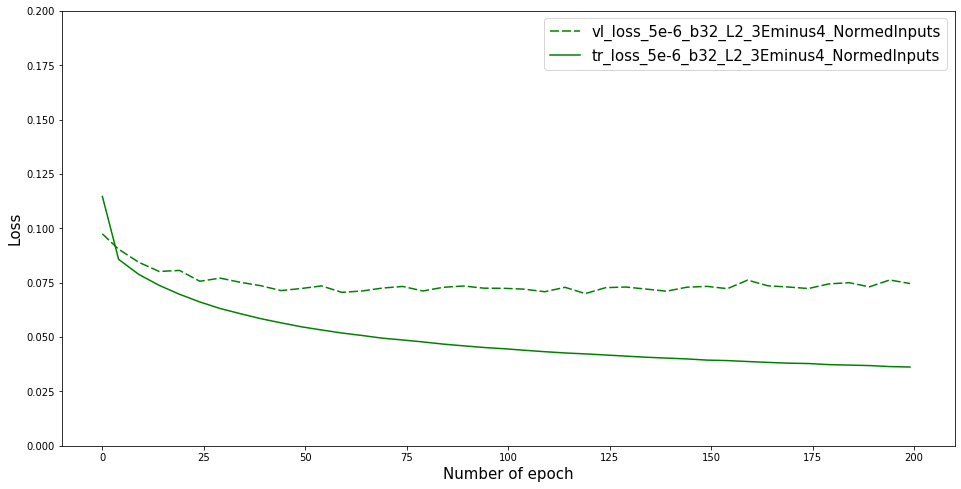

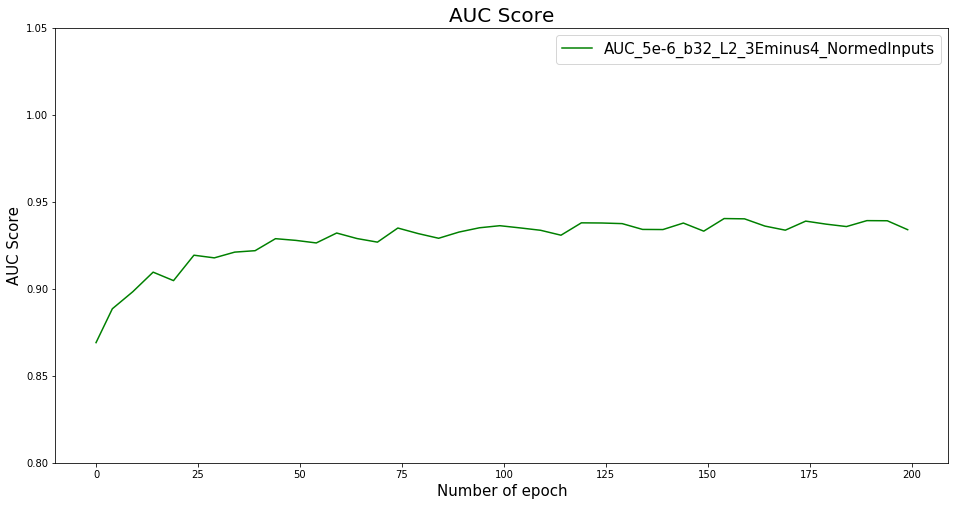

In [50]:
# ============== Our Best LEARNING RATE =================================
lnr_list = [5e-06]
wd = 3e-04

# Store training & validation loss at different lnr
tr_loss_lnr = []
vl_loss_lnr = []

# START
for lnr in lnr_list:
    print('='*30)
    print('LEARNING RATE = ', lnr, '; Batch size = ', batchsize, '; wd = ', wd)
    
    import time
    tic = time.time()

    # ======================= MODEL ===========================
    # We need to initiate model at every new lnr to restart
    if gpu_use:
        torch.manual_seed(manualSeed)
        model_one = Model_one()
        model_one.cuda()
    else:
        torch.manual_seed(manualSeed)
        model_one = Model_one()
    
    # Construct our loss function
    criterion = torch.nn.BCELoss(size_average=True) 

    # Construct our Optimizer
    optimizer = torch.optim.Adam(model_one.parameters(), lr=lnr, weight_decay=wd)
    # ==========================================================
    
    
    tr_loss = []  
    vl_loss = []
    auc_score = []
    ep = []

    for epoch in range(200):
        tr_loss_epoch = 0.
        n_batches = 0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
        
            # Wrap them in Variable:
            if gpu_use:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
        
            # Forward pass
            y_pred = model_one(inputs.float())
        
            # Compute and print loss
            loss = criterion(y_pred, labels.float())
            tr_loss_epoch += loss.detach().item() # sum up training loss in all batches for every epoch
            n_batches += 1 # count number of batches
        
            #print(epoch, i, loss.item())
        
            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    
        # Calculate loss on train & validation set and plot results
        # at certain frequency
    
        if(((epoch + 1)%5 == 0) or (epoch==0)):
            tr_loss_epoch = tr_loss_epoch/n_batches
            tr_loss.append(tr_loss_epoch)
        
            y_val_pred = model_one(x_val.float())
            loss_val = criterion(y_val_pred, y_val.float())
            vl_loss.append(loss_val.detach().item())
        
            auc = metrics.roc_auc_score(vl_y, y_val_pred.cpu().detach().numpy())
            auc_score.append(auc)
          
            print(epoch, tr_loss_epoch, loss_val.item(), auc)#.data[0])
     

            ep.append(epoch)
        
    
    tr_loss_lnr.append(tr_loss[-1]) # save training loss at last epoch for every learning rate
    vl_loss_lnr.append(vl_loss[-1]) # save validation loss at last epoch for every learning rate
    
    auc = metrics.roc_auc_score(vl_y, y_val_pred.cpu().detach().numpy())
    print(' ')
    print('Performance on Validation set')
    print('AUC : ', auc, '; LNR : ', lnr, '; Weight decay = ', wd)
    
    toc = time.time()
    print('running time: ', (toc - tic)/60)
    
    
# Save results 
# lnr = 5e-06
tr_loss_lnr5Eminus6_7L_200ep_B32_L2_3Eminus4 = tr_loss.copy()
vl_loss_lnr5Eminus6_7L_200ep_B32_L2_3Eminus4 = vl_loss.copy()
auc_lnr5Eminus6_7L_200ep_B32_L2_3Eminus4 = auc_score.copy()
ep200 = ep.copy()


# ==============================================
# =============== PLOTS ========================

# Plot Loss results
plt.figure(figsize = (16,8))
plt.plot(ep200, vl_loss_lnr5Eminus6_7L_200ep_B32_L2_3Eminus4, color = 'green', dashes=[6, 2], label = 'vl_loss_5e-6_b32_L2_3Eminus4_NormedInputs')
plt.plot(ep200, tr_loss_lnr5Eminus6_7L_200ep_B32_L2_3Eminus4, color = 'green', label = 'tr_loss_5e-6_b32_L2_3Eminus4_NormedInputs')


plt.xlabel('Number of epoch', size = 15)
plt.ylabel('Loss', size = 15)
plt.ylim(0,0.2)
plt.xlim(-10,210)
plt.legend(fontsize = 15)
plt.show()

# Plot AUC score
plt.figure(figsize = (16,8))
plt.plot(ep200, auc_lnr5Eminus6_7L_200ep_B32_L2_3Eminus4, color = 'green', label = 'AUC_5e-6_b32_L2_3Eminus4_NormedInputs')

plt.title('AUC Score', size = 20)
plt.xlabel('Number of epoch', size = 15)
plt.ylabel('AUC Score', size = 15)
plt.ylim(0.8,1.05)
plt.legend(fontsize = 15)
plt.show()